In [1]:
import socket,warnings
try:
    socket.setdefaulttimeout(1)
    socket.socket(socket.AF_INET, socket.SOCK_STREAM).connect(('1.1.1.1', 53))
except socket.error as ex: raise Exception("STOP: No internet. Click '>|' in top right and set 'Internet' switch to on")

In [2]:
# It's a good idea to ensure you're running the latest version of any libraries you need.
# `!pip install -Uqq ` upgrades to the latest version of 
# NB: You can safely ignore any warnings or errors pip spits out about running as root or incompatibilities
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

# U = upgrade, q = quiet
if iskaggle:
    path = Path("../input/titanic")
else:
    path = Path('titanic')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

## Import libraries and dataset

In [3]:
import torch, numpy as np, pandas as pd

np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

## Clean the data

In [4]:
df = pd.read_csv(path/'train.csv')
df

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


Check which columns contain NaN values

In [5]:
modes = df.mode().iloc[0]
modes

PassengerId                      1
Survived                       0.0
Pclass                         3.0
Name           Abbing, Mr. Anthony
Sex                           male
Age                           24.0
SibSp                          0.0
Parch                          0.0
Ticket                        1601
Fare                          8.05
Cabin                      B96 B98
Embarked                         S
Name: 0, dtype: object

In [6]:
df.fillna(modes, inplace=True)

In [7]:
# check for null values
df.isna().sum()

PassengerId    0
Survived       0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
dtype: int64

In [8]:
df.describe(include=(np.number))

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,28.566970,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,13.199572,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,22.000000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,24.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,35.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


<Axes: >

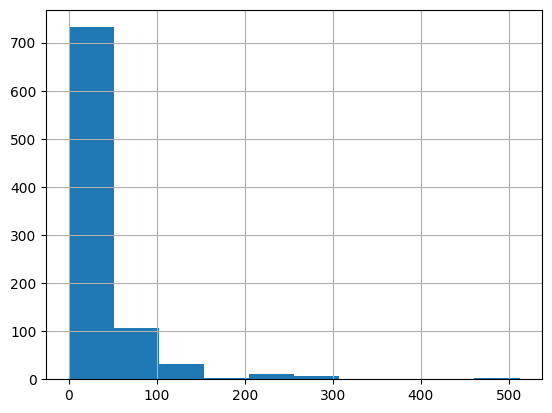

In [9]:
# this is a longtail distribution
df['Fare'].hist()

In [10]:
# apply log to prevent domination of data with high values over small values
df['LogFare'] = np.log(df['Fare'] + 1)

<Axes: >

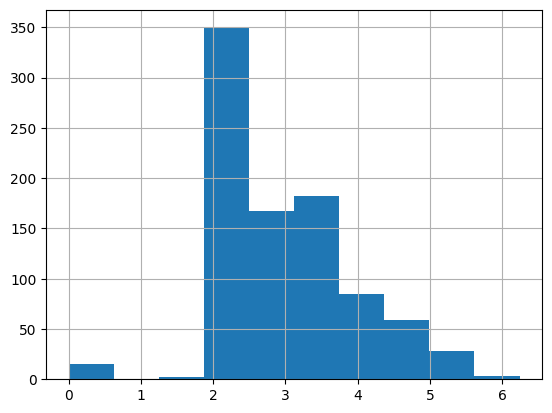

In [11]:
df['LogFare'].hist()

In [12]:
pclasses = sorted(df.Pclass.unique())
pclasses

[1, 2, 3]

In [13]:
df.describe(include=[object])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,891,891
unique,891,2,681,147,3
top,"Dooley, Mr. Patrick",male,1601,B96 B98,S
freq,1,577,7,691,646


In [14]:
# create dummies variables
df = pd.get_dummies(df, columns=['Sex', 'Pclass', 'Embarked'])
df.columns

Index(['PassengerId', 'Survived', 'Name', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'LogFare', 'Sex_female', 'Sex_male',
       'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S'],
      dtype='object')

In [15]:
added_cols = ['Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Embarked_C', 'Embarked_Q', 'Embarked_S']
df[added_cols].head()

,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S
0,False,True,False,False,True,False,False,True
1,True,False,True,False,False,True,False,False
2,True,False,False,False,True,False,False,True
3,True,False,True,False,False,False,False,True
4,False,True,False,False,True,False,False,True


In [16]:
from torch import tensor

# tensor: turn to array, Survived is our target variable
t_dep = tensor(df.Survived)

In [17]:
indep_cols = ['Age', 'SibSp', 'Parch', 'LogFare'] + added_cols

t_indep = tensor(df[indep_cols].to_numpy(dtype=np.float32), dtype=torch.float)
t_indep

tensor([[22.0000,  1.0000,  0.0000,  2.1102,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [38.0000,  1.0000,  0.0000,  4.2806,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000],
        [26.0000,  0.0000,  0.0000,  2.1889,  1.0000,  0.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  1.0000,  0.0000,  3.9908,  1.0000,  0.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        [35.0000,  0.0000,  0.0000,  2.2028,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [24.0000,  0.0000,  0.0000,  2.2469,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  1.0000,  0.0000],
        [54.0000,  0.0000,  0.0000,  3.9677,  0.0000,  1.0000,  1.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.0000],
        ...,
        [25.0000,  0.0000,  0.0000,  2.0857,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000,  0.0000,  0.0000,  1.0000],
        [39.0000,  0.0000,  5.0000,  3.4054

In [18]:
t_indep.shape

torch.Size([891, 12])

In [19]:
# len or rank of tensor, so we call it rank 2 of tensor
len(t_indep.shape)

2

## Setting up a linear model

In [20]:
torch.manual_seed(442)

n_coeff = t_indep.shape[1]

# get random coefficients
coeffs = torch.rand(n_coeff) - 0.5
coeffs

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625])

In [21]:
# multiply matrix by a vector: this is a broadcasting technique
# take each coefficient and multiply by every row in the matrix
# benefit of broadcasting: more concise and optimized in C code, fast
# indep = independences
t_indep*coeffs

tensor([[-10.1838,   0.1386,   0.0000,  -0.4772,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-17.5902,   0.1386,   0.0000,  -0.9681,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.4392,   0.0000,   0.0000],
        [-12.0354,   0.0000,   0.0000,  -0.4950,  -0.2632,  -0.0000,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.1386,   0.0000,  -0.9025,  -0.2632,  -0.0000,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        [-16.2015,   0.0000,   0.0000,  -0.4982,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.0000,   0.3625],
        [-11.1096,   0.0000,   0.0000,  -0.5081,  -0.0000,  -0.3147,   0.0000,   0.0000,   0.2799,  -0.0000,   0.2103,   0.0000],
        [-24.9966,   0.0000,   0.0000,  -0.8973,  -0.0000,  -0.3147,   0.4876,   0.0000,   0.0000,  -0.0000,   0.0000,   0.3625],
        ...,
        [-11.5725,   0.0000,   0.0000,  -0.4717,  -0.0000,  -0.3147,   0.0000

In [22]:
# 1st variable for every row has large magnitude because it's a Age feature
# it's not ideal so we're gonna divide them with the maximum of the row
vals, indices = t_indep.max(dim=0)

# element wise division
t_indep /= vals

In [23]:
t_indep*coeffs

tensor([[-0.1273,  0.0173,  0.0000, -0.0765, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2199,  0.0173,  0.0000, -0.1551, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.4392,  0.0000,  0.0000],
        [-0.1504,  0.0000,  0.0000, -0.0793, -0.2632, -0.0000,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0173,  0.0000, -0.1446, -0.2632, -0.0000,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        [-0.2025,  0.0000,  0.0000, -0.0798, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.1389,  0.0000,  0.0000, -0.0814, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.2103,  0.0000],
        [-0.3125,  0.0000,  0.0000, -0.1438, -0.0000, -0.3147,  0.4876,  0.0000,  0.0000, -0.0000,  0.0000,  0.3625],
        ...,
        [-0.1447,  0.0000,  0.0000, -0.0756, -0.0000, -0.3147,  0.0000,  0.0000,  0.2799, -0.0000,  0.0000,  0.3625],
        [-0.2257,  0.0000,  0.2008, -0.1234

In [24]:
preds = (t_indep*coeffs).sum(axis=1)

In [25]:
preds[:10]

tensor([ 0.1412, -0.5725,  0.1494,  0.2571,  0.0453, -0.0448,  0.0792,  0.2961,  0.2128, -0.5770])

Since we're going to use gradient descent, we need to identify the loss metric

In [26]:
loss = torch.abs(preds-t_dep).mean()
loss

tensor(0.5200)

In [27]:
def calc_preds(coeffs, indeps):
    return (indeps*coeffs).sum(axis=1)

def calc_loss(coeffs, indeps, deps):
    return torch.abs(calc_preds(coeffs, indeps) - deps).mean()

## Doing Gradient Descent step

In [28]:
# requires_grad_ is an in-place operation
coeffs.requires_grad_()

tensor([-0.4629,  0.1386,  0.2409, -0.2262, -0.2632, -0.3147,  0.4876,  0.3136,  0.2799, -0.4392,  0.2103,  0.3625], requires_grad=True)

In [29]:
loss = calc_loss(coeffs, t_indep, t_dep)
loss

tensor(0.5200, grad_fn=<MeanBackward0>)

In [30]:
loss.backward()

In [31]:
coeffs.grad

tensor([-0.0483,  0.0118, -0.0041, -0.0804, -0.1975,  0.1111, -0.1235, -0.0426,  0.0797, -0.1886, -0.0617,  0.1639])

This tells us that if we increase the `Age` coefficients, the loss will go down

In [32]:
# function with underscore means an inplace operation
# subtract coefficients * learning rate (0.1)
with torch.no_grad():
    coeffs.sub_(coeffs.grad * 0.1)
    print(calc_loss(coeffs, t_indep, t_dep))

tensor(0.5056)


The loss has gone down from `0.5200` to `0.5056`

## Training the linear model

In [33]:
from fastai.data.transforms import RandomSplitter

trn_split, val_split = RandomSplitter(seed=42)(df)

In [34]:
val_split

(#178) [303,778,531,385,134,476,691,443,386,128...]

In [35]:
trn_indep, val_indep = t_indep[trn_split], t_indep[val_split]
trn_dep, val_dep = t_dep[trn_split], t_dep[val_split]

In [36]:
print(len(trn_indep), len(val_indep))

713 178


In [37]:
def update_coeffs(coeffs, lr):
    return coeffs.sub_(coeffs.grad * lr)

In [38]:
def one_epoch(coeffs, lr):
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    with torch.no_grad():
        update_coeffs(coeffs, lr)
        print(f"{loss: .3f}", end="; ")

In [39]:
def init_coeffs():
    return (torch.rand(n_coeff)-0.5).requires_grad_()

In [40]:
def train_model(epochs=30, lr=0.01):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    for i in range(epochs):
        one_epoch(coeffs, lr=lr)
    return coeffs

In [41]:
coeffs = train_model(18, lr=0.02)

 0.518;  0.515;  0.510;  0.501;  0.491;  0.480;  0.467;  0.453;  0.435;  0.411;  0.388;  0.366;  0.346;  0.328;  0.310;  0.295;  0.288;  0.298; 

In [55]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs.requires_grad_(False)))

In [56]:
show_coeffs

<function __main__.show_coeffs()>

## Measuring accuracy

In [57]:
preds = calc_preds(coeffs, val_indep)

In [58]:
results = val_dep.bool() == (preds > 0.5)
results[:16]

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True, False, False, False,  True,  True, False])

In [59]:
results.float().mean()

tensor(0.8258)

In [60]:
def acc(coeffs):
    return (val_dep.bool() == (calc_preds(coeffs, val_indep) > 0.5)).float().mean()

In [61]:
acc(coeffs)

tensor(0.8258)

## Using sigmoid

In [62]:
preds[:28]

tensor([    1.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.0000,     0.9996,     1.0000,     0.0000,     0.9994,     0.0000,
            0.0000,     0.0000,     0.9945,     0.0000,     0.0000,     0.0000,     1.0000,     0.0000,     0.1266,     0.0000,     0.0000,
            1.0000,     1.0000,     0.0000,     0.0000,     0.1974,     0.0000], grad_fn=<SliceBackward0>)

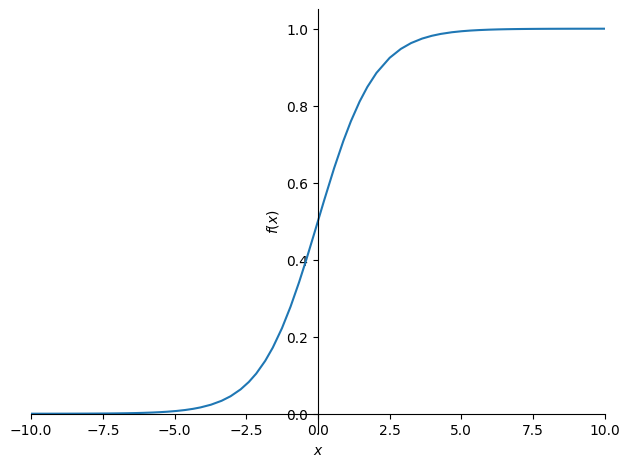

In [63]:
# sympy: symbolic python library
import sympy
sympy.plot("1/(1+exp(-x))", xlim=(-10,10))

In [64]:
# sigmoid can help the model optimizes better
def calc_preds(coeffs, indeps):
    return torch.sigmoid((indeps*coeffs).sum(axis=1))

In [65]:
coeffs = train_model(lr=2)

 0.503;  0.461;  0.391;  0.336;  0.306;  0.285;  0.265;  0.245;  0.228;  0.217;  0.210;  0.206;  0.205;  0.204;  0.204;  0.204;  0.204;  0.205;  0.205;  0.205;  0.205;  0.204;  0.204;  0.203;  0.202;  0.201;  0.200;  0.199;  0.197;  0.196; 

In [66]:
acc(coeffs)

tensor(0.8258)

In [67]:
show_coeffs()

{'Age': tensor(-1.6580),
 'SibSp': tensor(-1.2331),
 'Parch': tensor(-0.0658),
 'LogFare': tensor(1.9805),
 'Sex_female': tensor(16.4337),
 'Sex_male': tensor(-18.8047),
 'Pclass_1': tensor(7.7292),
 'Pclass_2': tensor(4.0682),
 'Pclass_3': tensor(-12.5092),
 'Embarked_C': tensor(3.2035),
 'Embarked_Q': tensor(1.0706),
 'Embarked_S': tensor(-5.9335)}

## Submitting to Kaggle

In [68]:
tst_df = pd.read_csv(path/'test.csv')

In [69]:
tst_df['Fare'] = tst_df.Fare.fillna(0)

In [70]:
tst_df.fillna(modes, inplace=True)
tst_df['LogFare'] = np.log(tst_df['Fare'] + 1)
tst_df = pd.get_dummies(tst_df, columns=['Sex', 'Pclass', 'Embarked'])


# tensor(df[indep_cols].to_numpy(dtype=np.float32), dtype=torch.float)
tst_indep = tensor(tst_df[indep_cols].to_numpy(dtype=np.float32), dtype=torch.float)
tst_indep /= vals

In [71]:
tst_df['Survived'] = (calc_preds(tst_indep, coeffs) > 0.5).int()

In [72]:
sub_df = tst_df[["PassengerId", 'Survived']]
sub_df.to_csv('sub.csv', index=False)

In [73]:
!head sub.csv

PassengerId,Survived
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


## Using matrix product

In [74]:
(val_indep*coeffs).sum(axis=1)

tensor([ 21.8975, -30.0529, -27.9389, -19.6750, -20.3506, -20.5479,   7.8810,  14.8256, -36.8329,   7.4655, -37.2160, -27.8882, -36.7033,
          5.1907, -37.3128, -16.8893, -17.3038,  15.0852, -20.4324,  -1.9309, -37.0512, -17.1173,  27.8901,  14.7271, -37.0000, -29.8715,
         -1.4027, -17.2416, -36.8799,   5.1860,  15.0109,  -1.9053, -36.9476, -37.1805,  21.7731,  -1.5863, -16.8546,  28.2186, -37.0457,
         -1.9866, -20.2887, -37.0457, -20.4025,  28.0829, -36.9628,  -1.7375, -36.5005, -36.9528, -30.0828,  -1.7952,  -9.7936, -36.9987,
        -36.9687, -37.1036, -20.4338, -20.5581, -30.0524, -37.2570, -36.9836, -36.9371,  -7.4279, -37.0918, -17.5773, -36.9880,  14.5483,
        -16.0714, -20.3299, -37.0323, -30.3478,  14.4844, -37.0927,   7.4934, -20.5374, -36.9986, -16.4614, -36.8897, -37.0457, -16.5192,
        -20.2263, -20.7642, -19.8393,  28.3697, -37.0305, -37.0751,  14.3072, -11.0367,  -6.9078,  19.2851,  23.9925, -20.3092, -37.2008,
        -37.0457,  28.2288, -28.06

In [75]:
# equivalent as above
val_indep@coeffs

tensor([ 21.8975, -30.0529, -27.9389, -19.6750, -20.3506, -20.5479,   7.8810,  14.8256, -36.8329,   7.4655, -37.2160, -27.8882, -36.7033,
          5.1907, -37.3128, -16.8893, -17.3038,  15.0852, -20.4324,  -1.9309, -37.0512, -17.1173,  27.8901,  14.7271, -37.0000, -29.8715,
         -1.4027, -17.2416, -36.8799,   5.1860,  15.0109,  -1.9053, -36.9476, -37.1805,  21.7731,  -1.5863, -16.8546,  28.2186, -37.0457,
         -1.9866, -20.2887, -37.0457, -20.4025,  28.0829, -36.9628,  -1.7375, -36.5005, -36.9528, -30.0828,  -1.7953,  -9.7936, -36.9987,
        -36.9687, -37.1036, -20.4338, -20.5581, -30.0524, -37.2570, -36.9836, -36.9371,  -7.4279, -37.0918, -17.5773, -36.9880,  14.5483,
        -16.0714, -20.3299, -37.0323, -30.3478,  14.4844, -37.0927,   7.4934, -20.5374, -36.9986, -16.4614, -36.8897, -37.0457, -16.5192,
        -20.2263, -20.7642, -19.8393,  28.3697, -37.0305, -37.0751,  14.3072, -11.0367,  -6.9078,  19.2851,  23.9925, -20.3092, -37.2008,
        -37.0457,  28.2288, -28.06

In [82]:
def calc_preds(coeffs, indeps):
    return torch.sigmoid(indeps@coeffs)

In [77]:
def init_coeffs():
    return (torch.rand(n_coeff, 1) * 0.1).requires_grad_()

In [78]:
# create trailing dimension to training dependence
trn_dep = trn_dep[:, None]
val_dep = val_dep[:, None]

In [79]:
trn_dep.shape

torch.Size([713, 1])

In [83]:
coeffs = train_model(lr=2)

 0.512;  0.469;  0.393;  0.331;  0.299;  0.280;  0.263;  0.245;  0.229;  0.217;  0.210;  0.206;  0.204;  0.203;  0.203;  0.203;  0.203;  0.203;  0.203;  0.204;  0.203;  0.203;  0.203;  0.202;  0.201;  0.200;  0.199;  0.198;  0.197;  0.196; 

In [84]:
acc(coeffs)

tensor(0.8258)

## A Neural network

In [85]:
# with 1 hidden layer
def init_coeffs(n_hidden=20):
    # 1 set of coefficients go from input to hidden
    layer1 = (torch.rand(n_coeff, n_hidden) - 0.5) / n_hidden
    
    # from hidden to single out
    layer2 = torch.rand(n_hidden, 1) - 0.3
    
    # single scaler random number
    const = torch.rand(1)[0] 
    
    return layer1.requires_grad_(), layer2.requires_grad_(), const.requires_grad_()

In [90]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    l1, l2, const = coeffs
    res = F.relu(indeps@l1)
    res = res@l2 + const
    return torch.sigmoid(res)

In [88]:
def update_coeffs(coeffs, lr):
    for layer in coeffs:
        layer.sub_(layer.grad * lr)

In [91]:
coeffs = train_model(lr=1.4)

 0.544;  0.533;  0.511;  0.467;  0.392;  0.302;  0.252;  0.225;  0.209;  0.203;  0.201;  0.200;  0.196;  0.193;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192;  0.192; 

In [92]:
acc(coeffs)

tensor(0.8258)

## Deep learning

In [102]:
def init_coeffs():
    hiddens = [10, 10]  # <-- set this to the size of each hidden layer you want
    sizes = [n_coeff] + hiddens + [1]
    n = len(sizes)
    layers = [(torch.rand(sizes[i], sizes[i+1])-0.3)/sizes[i+1]*4 for i in range(n-1)]
    consts = [(torch.rand(1)[0]-0.5)*0.1 for i in range(n-1)]
    for l in layers+consts: l.requires_grad_()
    return layers,consts

In [104]:
import torch.nn.functional as F

def calc_preds(coeffs, indeps):
    layers, consts = coeffs
    n = len(layers)
    res = indeps
    
    for i, l in enumerate(layers):
        res = res@l + consts[i]
        if i != n-1:
            res = F.relu(res) # final layer, sigmoid activation function
    return torch.sigmoid(res)

In [107]:
def update_coeffs(coeffs, lr):
    layers, consts = coeffs
    for layer in layers + consts:
        layer.sub_(layer.grad * lr)

In [108]:
coeffs = train_model(lr=1.4)

 0.514;  0.463;  0.348;  0.318;  0.208;  0.220;  0.224;  0.223;  0.217;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215;  0.215; 

In [109]:
acc(coeffs)

tensor(0.7921)